# **DS 4002 Project 2 Script**

Group GKI: Grace Brasselle, Kristy Luk (Leader), and Isabel O’Connor



### **Import Data and Data Cleaning**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt

# URL of the raw file
url = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/DS4002-Project2-Data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
df.head()

# Remove N/A values
df_cleaned = df.dropna()

### **Exploratory Data Analysis**

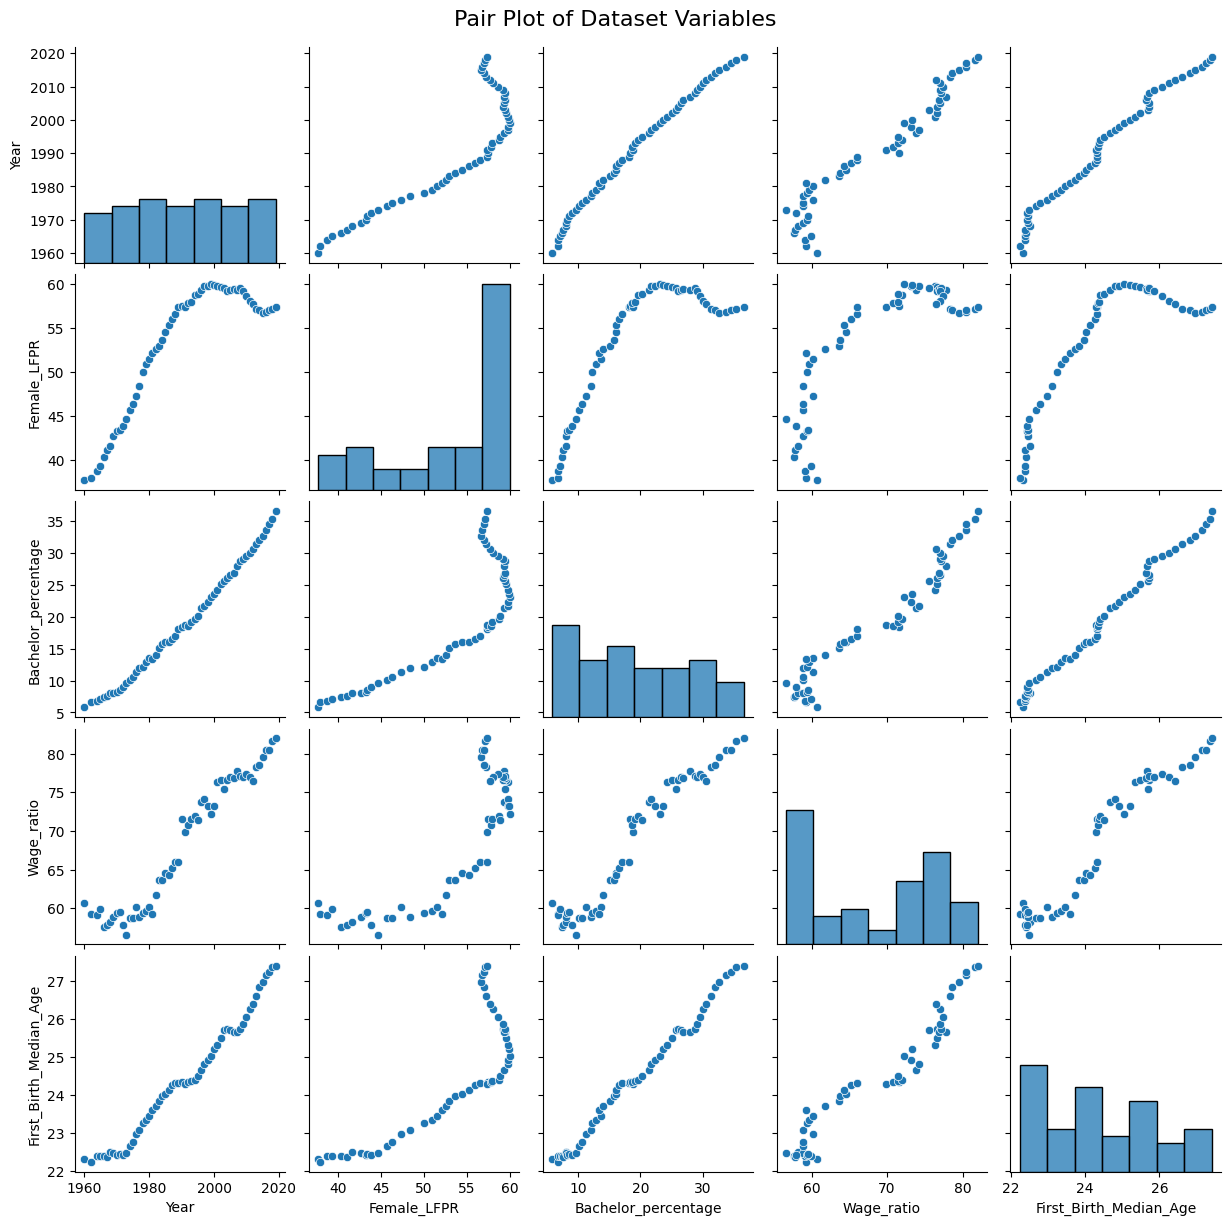

In [4]:
# We will first create a pair plot to look at the general distribution of variables
# as well as scatterplots between pairs of variables in the dataset

pair_plot = sns.pairplot(df_cleaned)

pair_plot.fig.suptitle("Pair Plot of Dataset Variables", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# From this graph, we can make a few interesting observations. Most of the variables in the dataset appear to 
# be positively correlated. A few appear to follow logistic paths. For instance, year appears to be positively 
# correlated to female labor force participation rate until just below the year 2000, at which point the correlation
# tapers off. This suggests that a social catalyst might have led to a decrease in the female labor force participation
# rate. A few other graphs in the matrix also observed a logistic trend.

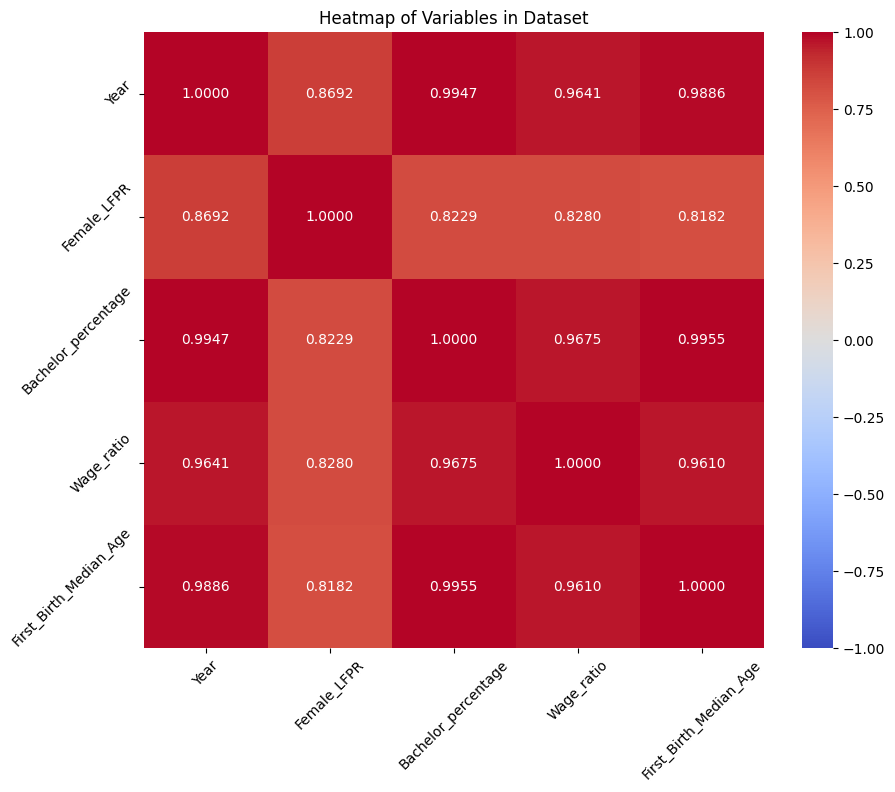

In [5]:
# The second plot will be a correlation heatmap which shows the correlation
# coefficients between respective variables in the dataset

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_cleaned.corr(), annot=True, fmt=".4f", cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.title('Heatmap of Variables in Dataset')
plt.show()

# We see here that many of the variables are highly correlated. This could introduce multicolinearity bias into our model.


/tmp/ipykernel_1907/3226918601.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=average_lfpt, x='Age_Group', y='Female_LFPR', palette='magma')


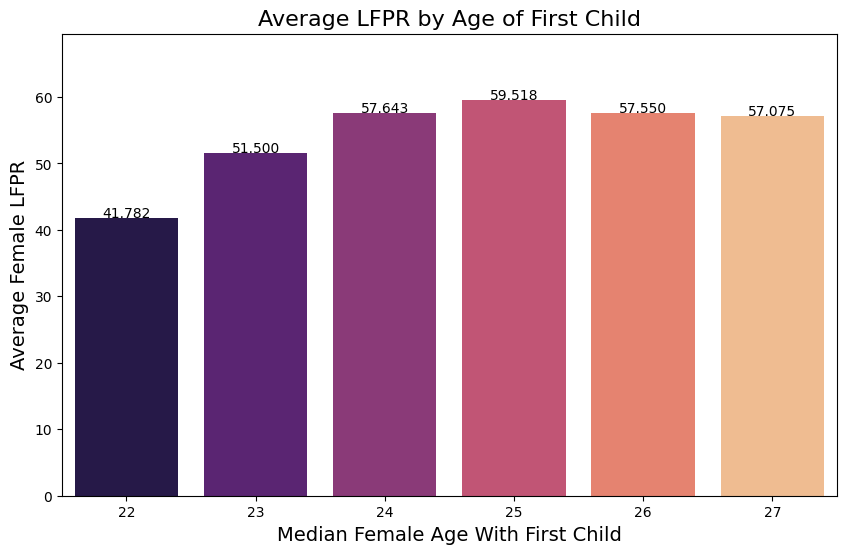

In [24]:
# Now we will create a bar graph looking at the average female LFPR vs the median
# age a women has their first child

df['Age_Group'] = df['First_Birth_Median_Age'].astype(str).str[:2]

average_lfpt = df.groupby('Age_Group')['Female_LFPR'].mean().reset_index()

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=average_lfpt, x='Age_Group', y='Female_LFPR', palette='magma')

for index, row in average_lfpt.iterrows():
    bar_plot.text(index, row['Female_LFPR'] + 0.1, f'{row["Female_LFPR"]:.3f}',
                  color='black', ha="center")

plt.title('Average LFPR by Age of First Child', fontsize=16)
plt.xlabel('Median Female Age With First Child', fontsize=14)
plt.ylabel('Average Female LFPR', fontsize=14)
plt.ylim(0, average_lfpt['Female_LFPR'].max() + 10)  # Adjust y-axis limit for visibility

plt.show()

# We see here that in years where the average maternal age at first birth was 22, the average 
# labor force participation rate for women was quite low at 41.78%. The histogram shows that female labor force
# participation increases as maternal age at first birth increases. However, this trend peaks at maternal age 25,
# before starting to decrease.

# This trend makes sense, as we saw from a scatterplot that female LFPR has tapered off over the years. 


### **ARIMA Modeling**

We will first be using the data from just the years 1960-2000 and predicting the values for the twenty-first years, 2001-2019. Then, we will compare the predicted values with the values we have already obtained in the originial dataset in a graph.

In [7]:
# Import needed libraries
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load in cleaned dataset for just years 1960-2000
url = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/20th_century_data.csv'

twenty = pd.read_csv(url)
twenty.head()

,Year,Female_LFPR,Bachelor_percentage,Wage_ratio,First_Birth_Median_Age
0,1960,37.7,5.8,60.7,22.32
1,1962,37.9,6.7,59.3,22.24
2,1964,38.7,6.8,59.1,22.38
3,1965,39.3,7.1,59.9,22.38
4,1966,40.3,7.4,57.6,22.39


#### **Choosing best ARIMA parameters**

##### The following code conducts various tests to determine which values of p, d, and q will be best suited for our model.

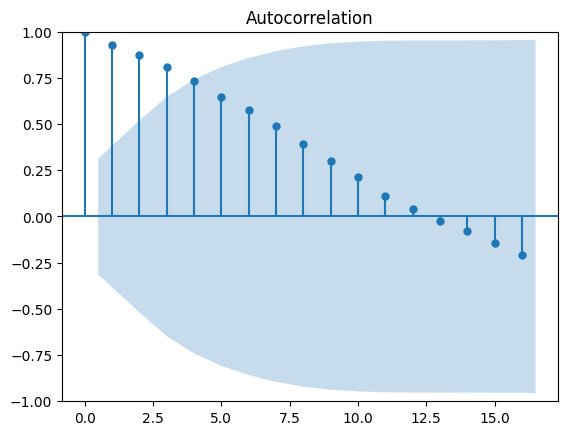

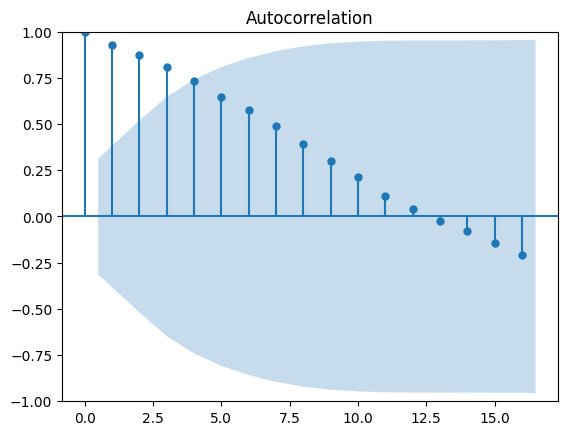

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(twenty.Wage_ratio)

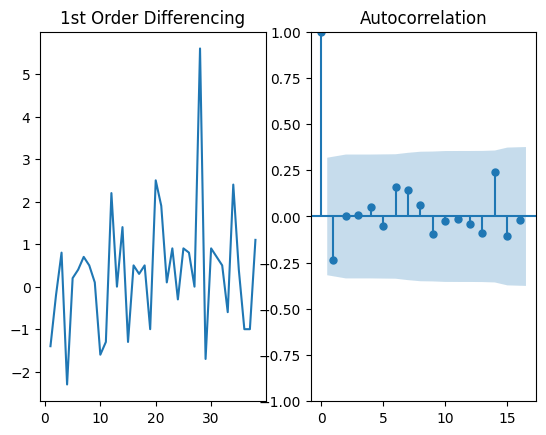

In [9]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(twenty.Wage_ratio.diff())
ax2 = f.add_subplot(122)
plot_acf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

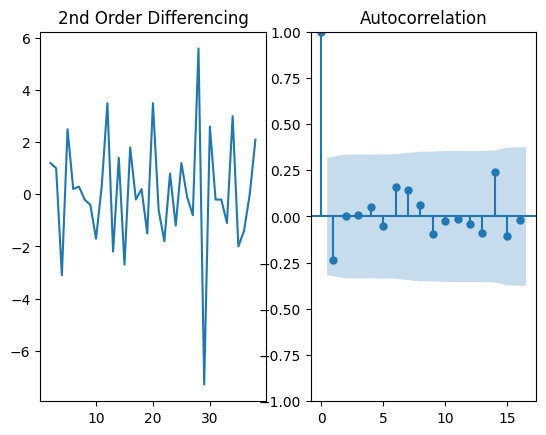

In [10]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(twenty.Wage_ratio.diff().diff())
ax2 = f.add_subplot(122)
plot_acf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller Test
# H0 = Time series non-stationary
# H1 = Time series is stationary

result = adfuller(twenty.Wage_ratio.dropna())
print('p value: ', result[1])

# First Differencing
result = adfuller(twenty.Wage_ratio.diff().dropna())
print('p value: ', result[1])

# Second Differencing
result = adfuller(twenty.Wage_ratio.diff().diff().dropna())
print('p value: ', result[1])

p value:  0.029983770167539794
p value:  1.6134859992644947e-11
p value:  0.00010345091848076797


In [12]:
import statsmodels.api as sm
# KPSS Test
# H0: The time series is trend stationary
# H1: The time series is not trend stationary

sm.tsa.stattools.kpss(twenty.Wage_ratio, regression='ct')


(np.float64(0.207634429618148),
 np.float64(0.013137088893194504),
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

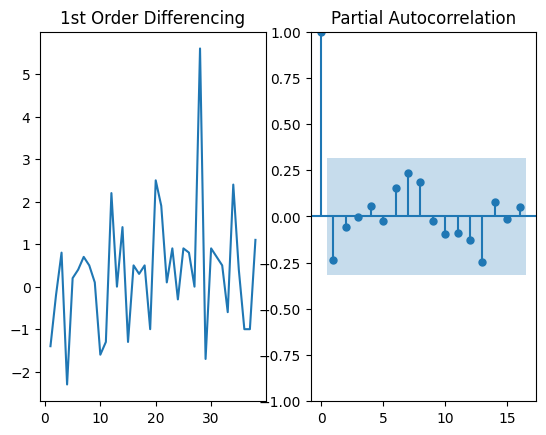

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(twenty.Wage_ratio.diff())
ax2 = f.add_subplot(122)
plot_pacf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

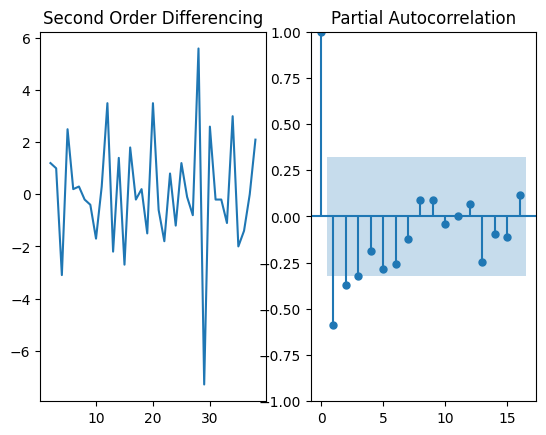

In [14]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Second Order Differencing')
ax1.plot(twenty.Wage_ratio.diff().diff())
ax2 = f.add_subplot(122)
plot_pacf(twenty.Wage_ratio.diff().diff().dropna(), ax=ax2)
plt.show()

#### **Now actually using the ARIMA model**

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmode

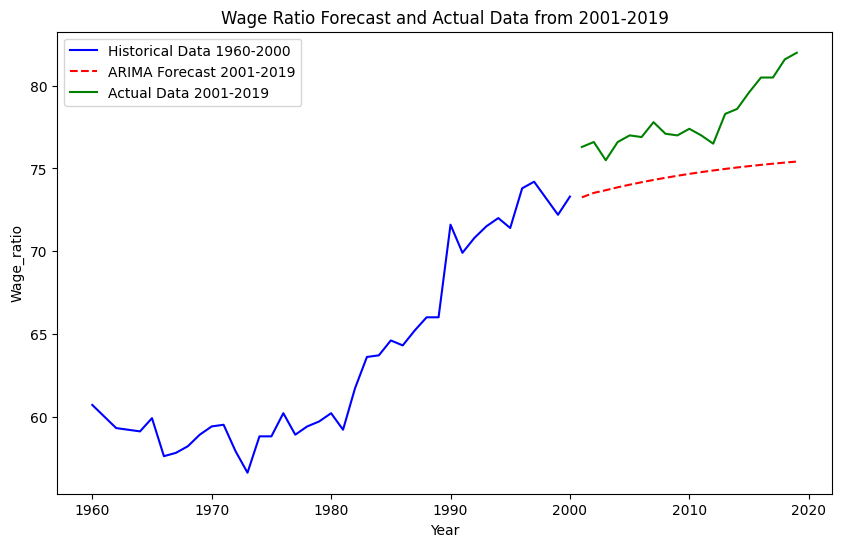

                               SARIMAX Results                                
Dep. Variable:             Wage_ratio   No. Observations:                   39
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -66.589
Date:                Tue, 22 Oct 2024   AIC                            141.179
Time:                        22:08:22   BIC                            147.729
Sample:                             0   HQIC                           143.509
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6482      0.587      1.103      0.270      -0.503       1.800
ar.L2          0.2686      0.233      1.155      0.248      -0.187       0.725
ma.L1         -0.8464      0.591     -1.433      0.1

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# This is the fully cleaned dataset
clean_data_path = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/DS4002-Project2-Data-CLEANED.csv'
clean_data = pd.read_csv(clean_data_path)

# Extract Year and Wage_ratio columns and filtering for years 2001-2019
clean_data.set_index('Year', inplace=True)
actual_data = clean_data.loc[2001:2019]
actual_years = actual_data.index
actual_wage_ratio = actual_data['Wage_ratio']

# Set index and target variable for ARIMA model using 1960-2000 data
historical_data = clean_data.loc[1960:2000]
y = historical_data['Wage_ratio']

# Fit the ARIMA model
model = ARIMA(y, order=(2, 1, 1))
model_fit = model.fit()

# Predict the Wage_ratio for 2001-2019
forecast_steps = 2019 - 2000
forecast_future = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.RangeIndex(start=2001, stop=2020)

# Plot the historical data, actual data, and predicted values for easy user readibility
plt.figure(figsize=(10, 6))
plt.plot(historical_data.index, historical_data['Wage_ratio'], label='Historical Data 1960-2000', color='blue')
plt.plot(forecast_index, forecast_future, label='ARIMA Forecast 2001-2019', color='red', linestyle='--')
plt.plot(actual_years, actual_wage_ratio, label='Actual Data 2001-2019', color='green', linestyle='-')

plt.title('Wage Ratio Forecast and Actual Data from 2001-2019')
plt.xlabel('Year')
plt.ylabel('Wage_ratio')
plt.legend()

plt.show()

print( model_fit.summary() )

In [16]:
# We will noe create a table showing the predicted wage ratios from the model vs
# the actual wage ratios from 2001-2019

predicted_wage_ratio = pd.DataFrame({
    'Year': forecast_index,
    'Predicted_Wage_Ratio': forecast_future
})

predicted_wage_ratio['Actual_Wage_Ratio'] = actual_wage_ratio.values

print("Predicted and Actual Wage Ratio for 2001-2019:")
print(predicted_wage_ratio)

Predicted and Actual Wage Ratio for 2001-2019:
    Year  Predicted_Wage_Ratio  Actual_Wage_Ratio
39  2001             73.256089               76.3
40  2002             73.523076               76.6
41  2003             73.684339               75.5
42  2004             73.860579               76.6
43  2005             74.018129               77.0
44  2006             74.167588               76.9
45  2007             74.306782               77.8
46  2008             74.437149               77.1
47  2009             74.559038               77.0
48  2010             74.673060               77.4
49  2011             74.779707               77.0
50  2012             74.879459               76.5
51  2013             74.972761               78.3
52  2014             75.060031               78.6
53  2015             75.141659               79.6
54  2016             75.218009               80.5
55  2017             75.289422               80.5
56  2018             75.356219               81.6
57 

### **Mean Squared Error and Residual Errors**

##### The last step is to calculate the MSE, RMSE, and residuals to evaluate the efficacy of our model.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Combing the predicted and actual wage ratios into one dataframe
predicted_wage_ratio = pd.DataFrame({
    'Year': forecast_index,
    'Predicted_Wage_Ratio': forecast_future
})
actual_wage_ratio_df = pd.DataFrame({
    'Year': actual_years,
    'Actual_Wage_Ratio': actual_wage_ratio.values
})
wage_ratio_all = pd.merge(predicted_wage_ratio, actual_wage_ratio_df, on='Year', how='inner')

# Calculating MSE and RMSE
mse = mean_squared_error(actual_wage_ratio, forecast_future)
print(f"MSE = {mse:.4f}")
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

# Calculating residuals
wage_ratio_all['Residuals'] = wage_ratio_all['Actual_Wage_Ratio'] - wage_ratio_all['Predicted_Wage_Ratio']

print("Predicted, Actual Wage Ratio, and Residuals for 2001-2019:")
print(wage_ratio_all)

# RMSE of 3.75 suggests moderate level of prediction error in our model

MSE = 14.0506
RMSE = 3.7484
Predicted, Actual Wage Ratio, and Residuals for 2001-2019:
    Year  Predicted_Wage_Ratio  Actual_Wage_Ratio  Residuals
0   2001             73.256089               76.3   3.043911
1   2002             73.523076               76.6   3.076924
2   2003             73.684339               75.5   1.815661
3   2004             73.860579               76.6   2.739421
4   2005             74.018129               77.0   2.981871
5   2006             74.167588               76.9   2.732412
6   2007             74.306782               77.8   3.493218
7   2008             74.437149               77.1   2.662851
8   2009             74.559038               77.0   2.440962
9   2010             74.673060               77.4   2.726940
10  2011             74.779707               77.0   2.220293
11  2012             74.879459               76.5   1.620541
12  2013             74.972761               78.3   3.327239
13  2014             75.060031               78.6   3.53996

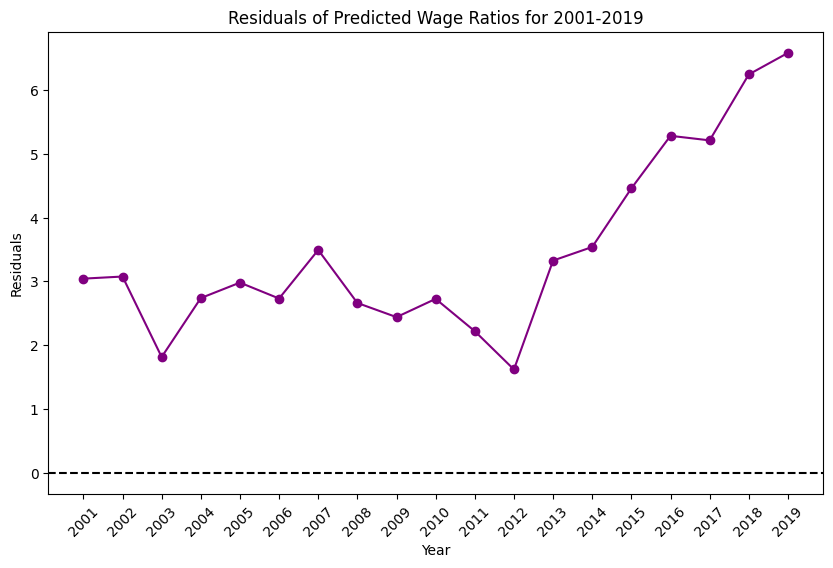

count    19.000000
mean      3.484116
std       1.420477
min       1.620541
25%       2.694895
50%       3.043911
75%       3.999155
max       6.581304
Name: Residuals, dtype: float64


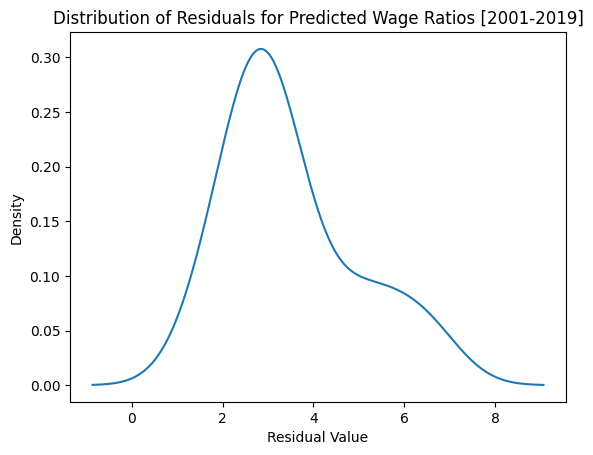

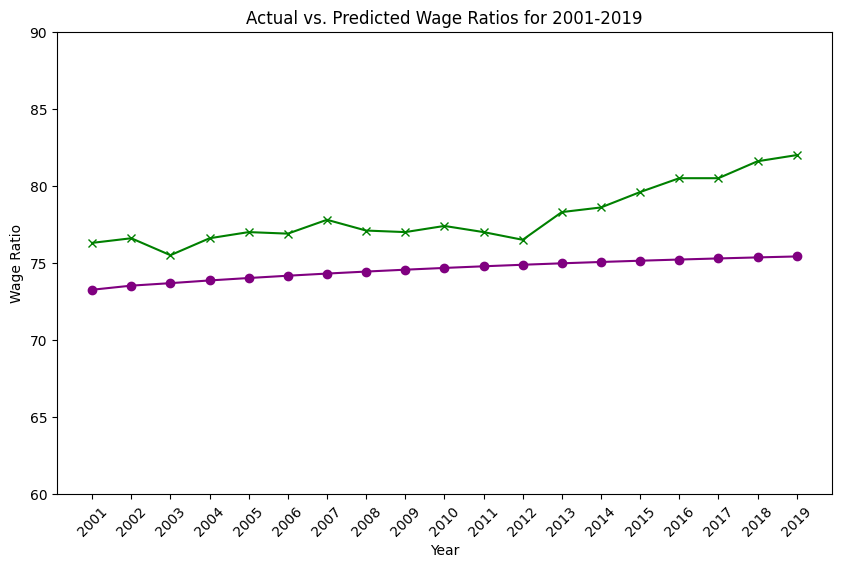

In [25]:
# Plotting residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Residuals'], marker='o', linestyle='-', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predicted Wage Ratios for 2001-2019')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.xticks(wage_ratio_all['Year'], rotation=45)
plt.show()

# the residual values seem to increase over time, suggesting that the wage gap prediction 
# accuracy is decreasing as the years progress. This suggests that there is trend information 
#  which was not captured in our model.

# Making a kernel density plot for the residuals. The distribution seems to be uniform and centered around 3.
# It's interesting that no residuals are negative.
ax = wage_ratio_all[ "Residuals" ].plot.kde()
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.title('Distribution of Residuals for Predicted Wage Ratios [2001-2019]')
# Let's describe the residual distribution:
print(wage_ratio_all[ "Residuals" ].describe())
# This mean value of the residuals is 3.4, which is higher than zero. This suggests bias in our ARIMA modeling approach.

# plotting the actual vs. predicted values for the entire dataset:

plt.figure(figsize=(10, 6))
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Predicted_Wage_Ratio'], marker='o', linestyle='-', color='purple')
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Actual_Wage_Ratio'], marker='x', linestyle='-', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Actual vs. Predicted Wage Ratios for 2001-2019')
plt.xlabel('Year')
plt.ylabel('Wage Ratio')
plt.ylim(60, 90)
plt.xticks(wage_ratio_all['Year'], rotation=45)
plt.show()

# From this graph, we can see that the marginal rate of increase for wage ratio spiked in 2012. 
# Because the predictive model fails to increase in slope here, it makes sense why the residual values would begin
# to spike.